# Example1: Linear Regression with Sampling

In [ ]:
#data manipulation packages
import numpy as np
import pandas as pd

#visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

#MCMC package
import pymc3 as pm

## Toy example with generated data

Our toy sample consists of 100 data points generated as following: 

<br>
<img src='lr.png' width=400>

In [11]:
np.random.seed(42)

#setup parameters
N = 100
w_0 = 2.5
w = np.array([0.9])
sigma2 = 0.5

#generate explainatory variable
noise = np.random.normal(0, np.sqrt(sigma2), size=N)
x = np.sort(np.random.normal(10, 1, size=N))

#generate dependent variable
y_truth = w_0 + x * w 
y = y_truth + noise

Here is how the generated data looks like:

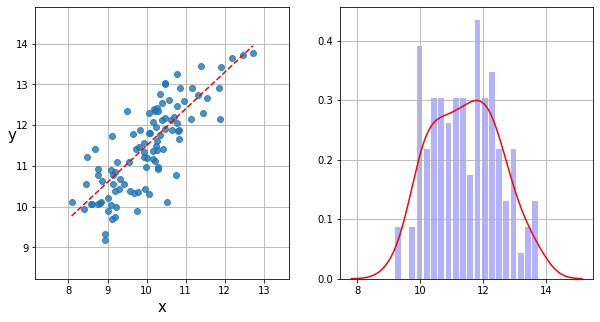

In [12]:
#scatter plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x,y,'o',alpha=0.8)
plt.grid()
plt.margins(0.2)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15, rotation=0)
plt.plot(x,y_truth,'r--')

#density and histogram
plt.subplot(1,2,2)
plt.grid()
plt.hist(y,bins=20,rwidth=0.8, density=True, color='b', alpha=0.3)
_=sns.kdeplot(y,color='r')

## Define a probabilistic model

In [14]:
#Zero mean the data (works better for regression tasks) 
x_c = (x - np.mean(x))

lin_reg = pm.Model()

with lin_reg:
    
    w_0 = pm.Normal('w_0', 0, 10) 
    w = pm.Normal('w', 0, 1)
    
    sigma = pm.Gamma('sigma', alpha=1, beta=0.5) # fixed noise hyperparameters
    
    y_hat = pm.Normal('y', mu=w_0 + w*x_c, sd=sigma, observed=y) # <- likelihood function

## Sample the Linear Regresion Model

In [17]:
import time
time0 = time.time() #notice start time to measure the computation time

with lin_reg:
    m_step = pm.Metropolis() # Define sampler
    map_start = pm.find_MAP() # Sampling start point as MAP estimator 
    
    trace = pm.sample(draws=10000, step=m_step, start=map_start, tune=100, chains=3)

time1 = time.time()
print("Estimation time: ", time1 - time0)

logp = -103.32, ||grad|| = 2.334: 100%|████████████████████████████████████████████████| 39/39 [00:00<00:00, 43.37it/s]
Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w]
>Metropolis: [w_0]
Sampling 3 chains, 0 divergences: 100%|███████████████████████████████████████| 30300/30300 [10:13<00:00, 49.42draws/s]
The number of effective samples is smaller than 10% for some parameters.


Estimation time:  955.9970324039459


## Plot the predicted model

In [19]:
w_0_hat = trace['w_0'].mean()
w_hat = trace['w'].mean()
sigma = trace['sigma'].mean()

print(f"w_0: {w_0_hat:0.3f} w: {w_hat:0.3f} sigma: {sigma:0.3f}") 

w_0: 11.445 w: 0.909 sigma: 0.654


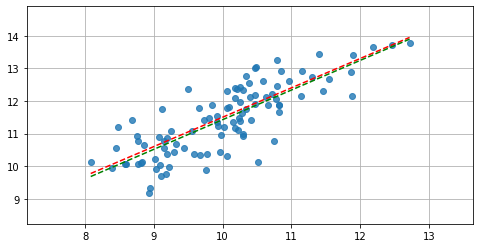

In [20]:
y_hat = w_0_hat + x_c * w_hat

plt.figure(figsize=(8,4))
plt.plot(x,y,'o',alpha=0.8)
plt.grid()
plt.margins(0.2)
plt.plot(x,y_truth,'r--')
_=plt.plot(x,y_hat,'g--')

# Convergence diagnostics

The most straightforward approach for assessing convergence is based on simply plotting and inspecting traces and histograms of the observed MCMC sample, as was done in the cell above. If the trace of values for each of the stochastics exhibits asymptotic behavior over the last 𝑚 iterations, this may be satisfactory evidence for convergence.

## Informal methods
### 1) Summary statistics for the sampled traces

In [7]:
pm.stats.summary(trace, varnames=['w_0', 'w','sigma'], alpha = 0.5)

,mean,sd,mc_error,hpd_25,hpd_75,n_eff,Rhat
w_0,11.445500,0.066498,0.001874,11.406352,11.496193,1287.865551,1.001067
w,0.906297,0.069643,0.001971,0.872811,0.960870,1315.171170,1.001348
sigma,0.652432,0.046510,0.001134,0.605586,0.667676,1709.192237,0.999955


### 2) Analysis of the trace plot

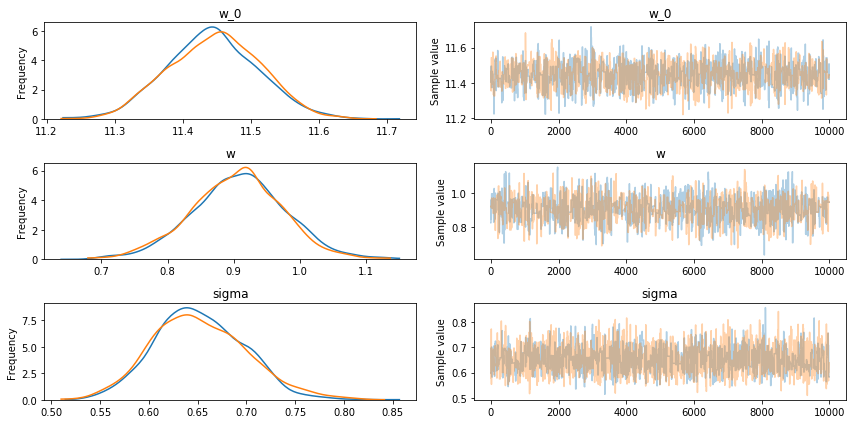

In [8]:
_= pm.traceplot(trace)

### Formal Methods

Along with the *ad hoc* techniques described above, a number of more
formal methods exist which are prevalent in the literature. These are
considered more formal because they are based on existing statistical
methods, such as time series analysis.

PyMC and ArviZ currently include a handful formal convergence diagnostic methods.  A commonly-applied metric is the Gelman-Rubin statistic [Gelman and Rubin (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011136). This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to
converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to assessing convergence. That is, it calculates both the between-chain varaince (B) and within-chain varaince (W), and assesses whether they are different enough to worry about convergence. Assuming $m$ chains, each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each chain, this quantity will overestimate the true marginal posterior variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit as $n \rightarrow  \infty$, both quantities will converge to the true variance of $\theta$. In light of this, the Gelman-Rubin statistic monitors convergence using the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of the potential reduction in the scale of $\theta$ as the number of simulations tends to infinity. In practice, we look for values of $\hat{R}$ close to one (say, less than 1.1) to be confident that a particular estimand has converged. In PyMC, the function `gelman_rubin` will calculate $\hat{R}$ for each stochastic node in the passed model:

## 4)  

## 5)

## Sample from the predicted posterior distribution

In [19]:
with lin_reg:
    ppc = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1582.35it/s]


In [20]:
ppc['y'].shape

(1000, 100)

In [22]:
y_pp = ppc['y']
y_pp_mean = y_pp.mean(0)
y_pp_var = y_pp.var(0)

y_pp_mean.shape

(100,)

## Plot different posterior density regions 

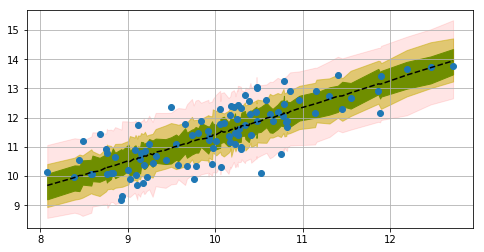

In [23]:
plt.figure(figsize=(8,4))
plt.plot(x,y,'o')
plt.plot(x,y_pp_mean,'k--')
#plt.fill_between(x, y_pp_mean - y_pp_var, y_pp_mean + y_pp_var, color='g', alpha=0.9)

sig0 = pm.hpd(ppc['y'], alpha=0.5)
sig1 = pm.hpd(ppc['y'], alpha=0.25)
sig2 = pm.hpd(ppc['y'], alpha=0.05)

plt.fill_between(x, sig0[:,0], sig0[:,1], color='g', alpha=1)
plt.fill_between(x, sig1[:,0], sig1[:,1], color='y', alpha=0.5)
plt.fill_between(x, sig2[:,0], sig2[:,1], color='r', alpha=0.1)

_= plt.grid()

# Shortcomings

## Robust Liner Regression

In [52]:
# Add some outliers

out = np.sort(np.random.multivariate_normal([12,20], 0.1*np.eye(2), size=50), axis=0)

x_out = np.append(x,out[:,0])
y_out = np.append(y,out[:,1])


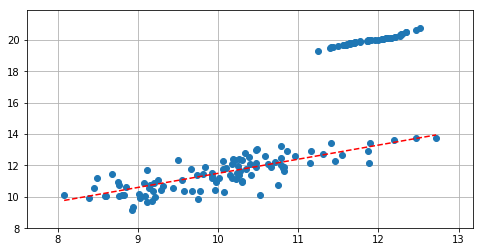

In [53]:
plt.figure(figsize=(8,4))
plt.plot(x_out,y_out,'o')
plt.grid()
plt.margins(0.1)
_=plt.plot(x,y_truth,'r--')

### Redefine the model with ouliered samples

In [54]:
#Zero mean the data (works better for regression tasks) 
x_c = (x_out - np.mean(x_out))

lin_reg = pm.Model()

with lin_reg:
    
    w_0 = pm.Normal('w_0', 0, 10) # Higher variance then for slope
    w = pm.Normal('w', 0, 1)
    
    #sigma = pm.Gamma('sigma', alpha=1., beta=0.5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    mu = pm.Deterministic('mu', w*x_c)
    
    y_hat = pm.Normal('y', mu = w_0 + mu, sd=sigma, observed = y_out)

In [56]:
with lin_reg:
    trace = pm.sample(draws=1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, w_0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3369.99draws/s]


In [57]:
w_0_hat = trace['w_0'].mean()
w_hat = trace['w'].mean()
sigma = trace['sigma'].mean()

print(f"w_0: {w_0_hat:0.3f} w: {w_hat:0.3f} sigma: {sigma:0.3f}") 
y_hat = w_0_hat + x_c * w_hat

w_0: 14.284 w: 2.858 sigma: 2.245


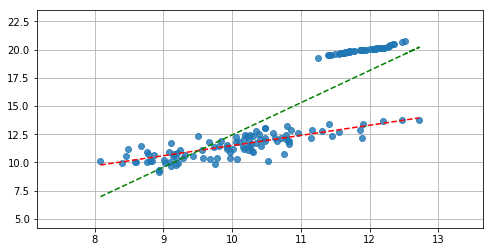

In [58]:
plt.figure(figsize=(8,4))

plt.plot(x_out,y_out,'o',alpha=0.8)
plt.grid()
plt.margins(0.2)
plt.plot(x,y_truth,'r--')
_=plt.plot(x_out,y_hat,'g--')

In [59]:
x_c = x_out - np.mean(x_out)

lin_rob = pm.Model()
with lin_rob:
    
    w_0 = pm.Normal('w_0', 0, 10) # Higher variance then for slope
    w = pm.Normal('w', 0, 1)
    
    sigma = pm.HalfCauchy('sigma', 5)
    
    mu = pm.Deterministic('mu', w*x_c)

    nu = pm.Deterministic('nu', pm.Gamma('nu_', alpha=10, beta=1) + 1) # Gaussianity parameter for Student-T

    y_hat = pm.StudentT('y', mu= w_0 + mu, sd=sigma, nu=nu, observed = y_out)

In [60]:
with lin_rob:
    trace = pm.sample(draws=2000, tune=500,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_, sigma, w, w_0]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2358.42draws/s]


In [61]:
pm.stats.summary(trace, varnames=['w_0','w','sigma', 'nu'], alpha=0.5)

,mean,sd,mc_error,hpd_25,hpd_75,n_eff,Rhat
w_0,14.381815,0.188020,0.002269,14.261577,14.509938,7588.242090,0.999895
w,2.977734,0.157888,0.001477,2.882260,3.091237,9874.137553,1.000021
sigma,2.100337,0.140549,0.001619,1.982709,2.168684,7821.332857,1.000350
nu,12.465136,3.193824,0.029897,9.704042,13.837835,7984.041035,0.999812


In [62]:
w_0_hat = trace['w_0'].mean()
w_hat = trace['w'].mean()
sigma = trace['sigma'].mean()

print(f"w_0: {w_0_hat:0.3f} w: {w_hat:0.3f} sigma: {sigma:0.3f}") 
y_hat = w_0_hat + x_c * w_hat

w_0: 14.382 w: 2.978 sigma: 2.100


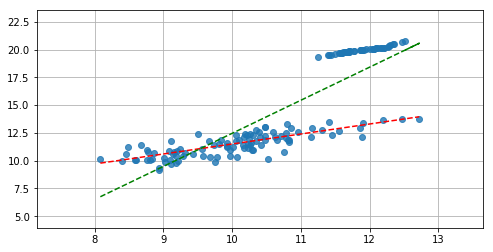

In [63]:
plt.figure(figsize=(8,4))

plt.plot(x_out,y_out,'o',alpha=0.8)
plt.grid()
plt.margins(0.2)
plt.plot(x,y_truth,'r--')
_=plt.plot(x_out,y_hat,'g--')